### Prediction and Evaluation of the trained model 

#### 01 - Import necessary and get last training job name

In [49]:
import boto3
import numpy as np
import pandas as pd
from env import (
    AWS_PROFILE_NAME,
    S3_BUCKET_NAME,
)

profile_name = AWS_PROFILE_NAME
bucket = S3_BUCKET_NAME

boto_session = boto3.Session(profile_name=profile_name)

sagemaker_client = boto_session.client("sagemaker")
s3_client = boto_session.client("s3")

subfolder_model: str = "models/hotel-reservations/xgboost"
subfolder_dataset: str = "datasets/hotel-reservations"

response = sagemaker_client.list_training_jobs(
    SortBy="CreationTime", SortOrder="Descending", MaxResults=1
)

last_training_job_name: str = response["TrainingJobSummaries"][0]["TrainingJobName"]

s3_model_data: str = f"{subfolder_model}/{last_training_job_name}/output/model.tar.gz"
s3_test_data: str = f"{subfolder_dataset}/test/hotel-reservations-test-data-xgboost"

s3_train_data: str = f"{subfolder_dataset}/train/hotel-reservations-train-data-xgboost"

zipped_model_folder: str = "./download/model.tar.gz"
dataset_test_folder: str = "./download/test-data-xgboost.csv"
xgboost_model_file: str = "./model/xgboost-model"

#### 02 - Download model and test data from s3, extract and read 

In [50]:
s3_client.download_file(bucket, s3_model_data, zipped_model_folder)
s3_client.download_file(bucket, s3_test_data, dataset_test_folder)

In [51]:
df_test = pd.read_csv(dataset_test_folder)

In [52]:
X_test = np.array(df_test.iloc[:, 1 : df_test.shape[1]].values).astype(np.float32)
y_test = np.array(df_test.iloc[:, 0].values).astype(np.float32)

In [53]:
import os
import tarfile

with tarfile.open(zipped_model_folder) as tar:
    tar_list = tar.getnames()
    print("Files in the tar archive:", tar_list)

    # Extract all files
    tar.extractall("./model")


if os.path.exists(xgboost_model_file):
    with open(xgboost_model_file, "rb") as f:
        file_header = f.read(4)
        print("File header:", file_header)

Files in the tar archive: ['xgboost-model']
File header: b'binf'


#### 03 - Execute model predictions

In [54]:
import xgboost as xgb

model = xgb.Booster()
model.load_model(xgboost_model_file)

dtest = xgb.DMatrix(X_test)

In [55]:
predictions = model.predict(dtest)
predictions

array([1., 0., 1., ..., 1., 1., 2.], dtype=float32)

#### 04 - Execute model evaluations

              precision    recall  f1-score   support

           1       0.88      0.83      0.85      3169
           2       0.79      0.84      0.81      3787
           3       0.88      0.88      0.88      3318

    accuracy                           0.85     10274
   macro avg       0.85      0.85      0.85     10274
weighted avg       0.85      0.85      0.85     10274

Accuracy:  0.847771072610473


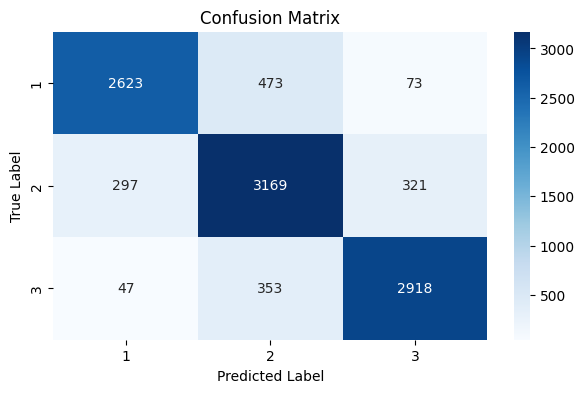

In [56]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(
    classification_report(
        np.array(y_test + 1).astype(int), np.array(predictions + 1).astype(int)
    )
)

print("Accuracy: ", accuracy_score(y_test, predictions))

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(7, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[1, 2, 3],
    yticklabels=[1, 2, 3],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### 05 - Delete all after predictions and evalutions

In [57]:
import os

try:
    os.remove(dataset_test_folder)
    os.remove(zipped_model_folder)
    os.remove(xgboost_model_file)
except Exception as err:
    pass